In [1]:
'''
(C) Renata Wong (2023)

Qiskit - PennyLane code for testing fidelity of randomised and derandomised classical shadows 
on the ground state energy of molecules. The present notebook uses the example of H2. 
For other molecules one just needs to specify the PYSCFDriver. 

For the randomized classical shadow: 
1. Choose an ansatz and run VQE using the Hamiltonian obtained from PySCFDriver in Qiskit. 
   VQE minimizes the expectation value of the Hamiltonian to obtain the ground state energy (-> minimal eigenvalue)
   Output: set of angles for the ansatz corresponding to the found ground state energy approximation
2. Calculate the size N of the shadow (= number of measurements, each measurement may use the same or different observable)
3. Generate N random Pauli operators U. 
   These N operators correspond to the number of measurements as the operators may repeat. 
4. Apply the random Pauli operators U to the ansatz with optimal angles (without the Hamiltonian).
   Store the measurement outputs in classical memory. (==> shadow)
5. Use the stored shadow to reconstruct the state:
   Input: the Hamiltonian obtained from PySCFDriver as observables, the shadow obtained in 4

For the derandomized classical shadow:
1. Input: Random measurements obtained in 3. above (these will be derandomized) 
2. Apply the derandomized Pauli operators U to the ansatz with optimal angles (without the Hamiltonian).
   Store the measurement outputs in classical memory. (==> shadow)
3. Use the stored shadow to reconstruct the state:
   Input: the Hamiltonian obtained from PySCFDriver as observables, the shadow obtained in 2
'''


from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

'''
# BeH2

driver = PySCFDriver(
    atom="Be 0 0 0; H 0 0 1.3264; H 0 0 -1.3264",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
'''

problem = driver.run()

hamiltonian = problem.hamiltonian
#coefficients = hamiltonian.electronic_integrals

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


-0.8105479805373234 * IIII
+ 0.1721839326191557 * IIIZ
- 0.2257534922240249 * IIZZ
+ 0.1721839326191554 * IZII
- 0.22575349222402488 * ZZZI
+ 0.1209126326177664 * IIZI
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


In [2]:
#Get the weights for the BK-encoded Hamiltonian
# Warning: the order of terms in the Hamiltonian can change slightly in each run!

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

print(hamiltonian_terms)
print(weights)

[[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
[-0.8105479805373234, 0.1721839326191557, -0.2257534922240249, 0.1721839326191554, -0.22575349222402488, 0.1209126326177664, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]


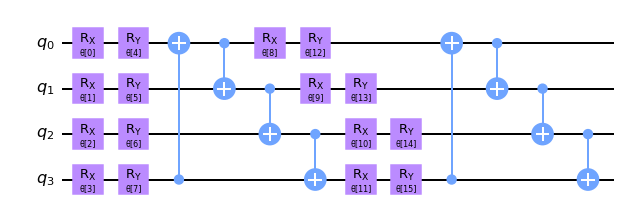

In [3]:
# Hardware-efficient ansatz
from qiskit.circuit.library import TwoLocal, EfficientSU2

#ansatz = TwoLocal(num_qubits=system_size, reps=10, rotation_blocks=['ry','rz'],
#                entanglement_blocks='cz', skip_final_rotation_layer=True)

reps = 2     # this value is later used in the PennyLane translation of the ansatz. 1-2 layers are enough for H2
ansatz = EfficientSU2(4, su2_gates=['rx', 'ry'], entanglement='circular', reps=2, skip_final_rotation_layer=True)

ansatz.decompose().draw('mpl')

In [4]:
# Classical minimum eigensolver

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
converter = QubitConverter(BravyiKitaevMapper())

# CLASSICAL solver to verify our vqe results
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
numpy_solver = NumPyMinimumEigensolver()   

# Optimisation process for the classical solver
calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Optimization using classical minimum eigensolver:\n', res) 

Optimization using classical minimum eigensolver:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [5]:
# Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
# NOTE: VQE performs sometimes much worse than VQEUCCFactory

# QUANTUM with REGULAR HAMILTONIAN 
from qiskit.algorithms.optimizers import SLSQP

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator    

from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.circuit.library import UCCSD
estimator = Estimator()
#vqe_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP(maxiter=20))
vqe_solver = VQE(estimator, ansatz, SLSQP(maxiter=15000))

# Optimisation
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
calc = GroundStateEigensolver(converter, vqe_solver)
result = calc.solve(problem)
print('Optimization using VQE solver with the regular Hamiltonian:\n', result)
print(result.raw_result)

Optimization using VQE solver with the regular Hamiltonian:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857274571016
  - computed part:      -1.857274571016
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137305576567
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894821]
    - computed part:      [0.0  0.0  1.38894821]
  > Dipole moment (a.u.): [0.0  0.0  0.00000049]  Total: 0.00000049
                 (debye): [0.0  0.0  0.00000125]  Total: 0.00000125
 
{   'aux_operators_evaluated': {   'AngularMomentum': (   5.157693604429525e-07,
                                                          {}),
                                   'Magnetization': (   -2.5460307476188326e-07,
                                                    

In [6]:
parameter_values = result.raw_result.optimal_point
print(parameter_values)                            # optimal angles for the ansatz
expected_value = result.raw_result.optimal_value
print(expected_value)     

[-1.17112440e-05 -3.14158266e+00 -1.54256747e-03 -3.14159265e+00
 -3.14142550e+00  2.91812435e+00  5.87864018e-05  3.14159265e+00
 -3.14159265e+00 -3.14159265e+00  3.14159265e+00  2.17042202e-04
  1.71462186e-04  6.40796824e-05 -5.41771033e-04  1.14234169e-04]
-1.8572745710162417


In [ ]:
# Running VQE on the Hamiltonian obtained form PySCFDriver using qasm simulator (Estimator in Qiskit Runtime)
# NOTE: Results with the ansatz are very bad. UCCSD performs much better! 

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
converter = QubitConverter(BravyiKitaevMapper())

from qiskit.algorithms.optimizers import SLSQP
  
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="2e41606b6a99fcc3bc51faffbb3bd61d94f704300ebffe6f52a5e21de38697122c0caffa1cbc5e3177a4eea067d8dbae31ec0e12161c0a267f2a6a80d4256a83")
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

from qiskit_ibm_runtime import Options
options = Options()
options.resilience_level = 1  #(1 = readout error mitigation)
options.execution.shots = 2000

estimator = Estimator(session=backend, options=options)

from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.circuit.library import UCCSD
#vqe_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP(maxiter=3000))
vqe_solver = VQE(Estimator(), ansatz, SLSQP(maxiter=10000))

# optimisation process for vqe with the standard Hamiltonian
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
calc = GroundStateEigensolver(converter, vqe_solver)
result = calc.solve(problem)
print('Optimization with VQE solver using the regular Hamiltonian:\n', result)

# Set of optimal angles for the ansatz that produces the best approximation to the ground state energy
print(result.raw_result)

/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verific

In [18]:
parameter_values = result.raw_result.optimal_point
print(parameter_values)
expected_value = result.raw_result.optimal_value
print(expected_value)

[ 11409.9728725  -20560.75393406   3028.25463028]
-1.2450092880418875


In [ ]:
'''
Get the matrix representation of the observables as a list (needed for shadow_bound)
This part is for testing only
import numpy as np
shadow_norm = (lambda op: np.linalg.norm(op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf) ** 2)
  
max_norm = 0
for observable in bkenc_hamiltonian:
    observable_norm = shadow_norm(observable.to_matrix().real)
    if observable_norm > max_norm:
        max_norm = observable_norm

print(max_norm)
#matrix_observables = [obs.to_matrix().real for obs in bkenc_hamiltonian]  # too big. kernel keeps dying
'''

In [7]:
# Calculate the required number of classical shadows 
# adapted for Qiskit from official Pennylane code

import numpy as np

def shadow_bound(error, observables, failure_rate=0.01):
    """
    Calculate the shadow bound for the Pauli measurement scheme.

    Implements Eq. (S13) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        error (float): The error on the estimator.
        observables (list) : List of matrices corresponding to the observables we intend to
            measure.
        failure_rate (float): Rate of failure for the bound to hold.

    Returns:
        An integer that gives the number of samples required to satisfy the shadow bound and
        the chunk size required attaining the specified failure rate.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(o) for o in observables) / error ** 2
    #print('N', N)
    #print(max(shadow_norm(o) for o in observables))
    return int(np.ceil(N * K)), int(K)

num_measurements, k = shadow_bound(error=2e-1, observables=[observable.to_matrix().real for observable in bkenc_hamiltonian])
print('Number of measurements N:', num_measurements)  

Number of measurements N: 2011984


In [8]:
# BeH2 requires 14 qubits (see also Flammia's paper)
#system_size = 14 # without core freeze and orbital removal. with core freeze system_size = 12. orbital removal not recommended.

system_size = 4                 # for H2

# Randomized classical shadow = applying randomized measurements instead of Hamiltonian observables
#from derand.data_acquisition_shadow import randomized_classical_shadow

num_measurements = 1000   # setting manually instead of the required number since processing time unknown for 2 million (> 5h).

#randomised_measurements = randomized_classical_shadow(num_measurements, system_size)

# convert the measurements to a Hamiltonian-like format for the gradient
#from qiskit.opflow import I, X, Y, Z, PauliSumOp

# need to convert to PauliSumOp for use in VQE
#paulis = [''.join(measurement) for measurement in randomised_measurements]
#paulis_with_weights = [(pauli, 1.0) for pauli in paulis]
#randomised_measurements_vqe = PauliSumOp.from_list(paulis_with_weights)
#print('The N randomly generated measurements:', sep='\n')
#print(randomised_measurements_vqe)


In [9]:
# Since Qiskit does not support extraction of expectation values on single qubits, we utilize PennyLane for that purpose.
# This involves:
# Translate the Qiskit ansatz into PennyLane
# Using another random set of unitaries instead of the one generated using Hsin-Yuan Huang's original code.

import pennylane as qml

dev = qml.device("default.qubit", wires=system_size, shots=1)

@qml.qnode(dev)
def ansatz(params, reps, observable):
    
    for iter in range(reps):
        for w in range(system_size):
            qml.RX(params[w + 2*iter*system_size], wires=w)
        for w in range(system_size):
            qml.RY(params[w + system_size + 2*iter*system_size], wires=w)

        qml.CNOT(wires=[system_size - 1, 0])
        for w in range(system_size - 1):
            qml.CNOT(wires=[w, w+1])
    
    return [qml.expval(o) for o in observable]     


# Calculate classical shadow based on the generated N random unitaries and ansatz with ground state energy angles
# Method from PennyLane

#from qiskit_aer import QasmSimulator
#backend = QasmSimulator(method='statevector')

def calculate_classical_shadow(ansatz, reps, params, shadow_size, num_qubits):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow. (N)
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))
    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        outcomes[ns, :] = ansatz(params, reps, observable=obs)
    
    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

    '''
    unitary_ids = []#np.zeros((shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))
    for index, measurement in enumerate(measurements):
        obs = []
        for ind, pauli in enumerate(measurement):
            if pauli == 'X':
                obs.insert(ind, 0)
            if pauli == 'Y':
                obs.insert(ind, 1) 
            if pauli == 'Z':
                obs.insert(ind, 2)
            #outcome[ind] = optimal_ansatz()
        # for each snapshot, add a random Pauli observable at each location
        unitary_ids.append(obs)
        
        outcomes[index, :] = ansatz(params, observable=obs)
        '''
    
num_qubits = system_size
shadow = calculate_classical_shadow(ansatz, reps, parameter_values, num_measurements, num_qubits)
#print(shadow[0])   # eigenvalues
#print(shadow[1])   # unitaries   

In [10]:
# Reconstructing states from shadows: helper functions
def snapshot_state(b_list, obs_list):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        b_list (array): The list of classical outcomes for the snapshot.  # row of the first matrix
        obs_list (array): Indices for the applied Pauli measurement.      # row of the second matrix

    Returns:
        Numpy array with the reconstructed snapshot.
    """

    num_qubits = len(b_list)

    # computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # local qubit unitaries
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex)    # this is the SSS gate, or phase shift by -pi/2
    hadamard = qml.matrix(qml.Hadamard(0))
    identity = qml.matrix(qml.Identity(0))

    # undo the rotations that were added implicitly to the circuit for the Pauli measurements in the X, Y and Z basis
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state   # state = |0><0| for eigenvalue 1, |1><1| for eigenvalue -1
        U = unitaries[int(obs_list[i])]

        # applying Eq. (S44)
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)    # kronecker product: mult each el in snapshot with each in local
        
    #print('local_rho\n', local_rho)
    #print('rho_snapshot\n', rho_snapshot)
    return rho_snapshot


def shadow_state_reconstruction(shadow):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.

    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots, num_qubits = shadow[0].shape

    # classical values
    b_lists, obs_lists = shadow

    # Averaging over snapshot states.
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])

    return shadow_rho / num_snapshots



# CALCULATING EXPECTATION VALUES FROM CLASSICAL SHADOWS
def estimate_shadow_obervable(shadow, observable, k=10):
    """
    Adapted from https://github.com/momohuang/predicting-quantum-properties
    Calculate the estimator E[O] = median(Tr{rho_{(k)} O}) where rho_(k)) is set of k
    snapshots in the shadow. Use median of means to ameliorate the effects of outliers.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        observable (qml.Observable): Single PennyLane observable consisting of single Pauli
            operators e.g. qml.PauliX(0) @ qml.PauliY(1).
        k (int): number of splits in the median of means estimator.

    Returns:
        Scalar corresponding to the estimate of the observable.
    """
    shadow_size, num_qubits = shadow[0].shape

    # convert Pennylane observables to indices
    map_name_to_int = {"PauliX": 0, "PauliY": 1, "PauliZ": 2}
    if isinstance(observable, (qml.PauliX, qml.PauliY, qml.PauliZ)):
        target_obs, target_locs = np.array(
            [map_name_to_int[observable.name]]
        ), np.array([observable.wires[0]])
    else:
        target_obs, target_locs = np.array(
            [map_name_to_int[o.name] for o in observable.obs]
        ), np.array([o.wires[0] for o in observable.obs])

    # classical values
    b_lists, obs_lists = shadow
    means = []

    # loop over the splits of the shadow:
    for i in range(0, shadow_size, shadow_size // k):

        # assign the splits temporarily
        b_lists_k, obs_lists_k = (
            b_lists[i : i + shadow_size // k],
            obs_lists[i : i + shadow_size // k],
        )

        # find the exact matches for the observable of interest at the specified locations
        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)

        # catch the edge case where there is no match in the chunk
        if sum(indices) > 0:
            # take the product and sum
            product = np.prod(b_lists_k[indices][:, target_locs], axis=1)
            means.append(np.sum(product) / sum(indices))
        else:
            means.append(0)

    return np.median(means)

In [12]:
# Translate the original Hamiltonian into PennyLane

from pennylane.pauli import PauliWord, string_to_pauli_word

pauli_words = []
wire_map = {'0' : 0, '1' : 1, '2' : 2, '3' : 3}

for index, terms in enumerate(hamiltonian_terms):
    if index > 0: 
        word = ""
        for term in terms:
            word += term[0]
        pauli_word = [string_to_pauli_word(word, wire_map=wire_map)]

        pauli_words.append(pauli_word)

print(pauli_words)

#wire_map = {'a' : 0, 'b' : 1, 'c' : 2}
#string_to_pauli_word('XIY', wire_map=wire_map)
# get PauliX(wires=['a']) @ PauliY(wires=['c'])

#list_of_observables = qml.pauli.PauliSentence({pauli_word:1.0 for pauli_word in pauli_words})  # dict comprehension
#qml.grouping.string_to_pauli_word


'''
def hamiltonian_from_qiskit(sum_op):
    
    
    #This function takes a qiskit.PauliSumOp as input and gives back a Pennylane Hamiltonian as output

    #sum_op  = qiskit.PauliSumOp
    
    op      = sum_op.primitive.to_list()
    n_terms = len(op)
    coeffs  = []
    paulis  = []

    for i in range(n_terms):
        paulis.append(qml.grouping.string_to_pauli_word(op[i][0]))
        coeffs.append(op[i][1].real)

    p_op = qml.Hamiltonian(coeffs,paulis)

    return p_op

pl_hamiltonian = hamiltonian_from_qiskit(bkenc_hamiltonian)
print(pl_hamiltonian)
'''

from pennylane.pauli import PauliWord, PauliSentence
#pw1 = qml.pauli.PauliWord({0:"X", 1:"Z"})  # X@Z
#pw2 = qml.pauli.PauliWord({0:"Y", 1:"Z"})  # Y@Z
#ps1 = qml.pauli.PauliSentence({pw1: 1.2, pw2: 0.5j}) # 1.2 * pw1 + 0.5j * pw2

pauli_words = []

for terms in hamiltonian_terms:
    term_dict = dict()
    for term in terms:
        term_dict[term[1]] = term[0]
        #term_dict[term[1]] = qml.PauliZ(wires=[0])
    pauli_word = qml.pauli.PauliWord(term_dict)
    pauli_words.append(pauli_word)
    
#list_of_observables = qml.pauli.PauliSentence({pauli_word:1.0 for pauli_word in pauli_words})  # dict comprehension

print(pauli_words)


op = qml.prod(qml.PauliX(0), qml.PauliZ(1))
op = qml.prod(qml.PauliY(2), op)
print(op)




#pauli_ops.pop(0)   # remove the empty element correspondign to the Hamiltonian term IIII 



list_of_observables = (
    [qml.PauliZ(3)] 
    + [qml.PauliZ(2) @ qml.PauliZ(3)]
    + [qml.PauliZ(1)]
    + [qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2)]
    + [qml.PauliZ(2)]
    + [qml.PauliZ(1) @ qml.PauliZ(3)]
    + [qml.PauliZ(0) @ qml.PauliX(1) @ qml.PauliX(3)]
    + [qml.PauliX(1) @ qml.PauliZ(2) @ qml.PauliX(3)]
    + [qml.PauliZ(0) @ qml.PauliX(1) @ qml.PauliZ(2) @ qml.PauliX(3)]
    + [qml.PauliX(1) @ qml.PauliX(3)]
    + [qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3)]
    + [qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3)]
    + [qml.PauliZ(0) @ qml.PauliZ(1)  @ qml.PauliZ(3)]
    + [qml.PauliZ(0) @ qml.PauliZ(2)]
)


[[PauliZ(wires=['3'])], [PauliZ(wires=['2']) @ PauliZ(wires=['3'])], [PauliZ(wires=['1'])], [PauliZ(wires=['0']) @ PauliZ(wires=['1']) @ PauliZ(wires=['2'])], [PauliZ(wires=['2'])], [PauliZ(wires=['1']) @ PauliZ(wires=['3'])], [PauliZ(wires=['0']) @ PauliX(wires=['1']) @ PauliX(wires=['3'])], [PauliX(wires=['1']) @ PauliZ(wires=['2']) @ PauliX(wires=['3'])], [PauliZ(wires=['0']) @ PauliX(wires=['1']) @ PauliZ(wires=['2']) @ PauliX(wires=['3'])], [PauliX(wires=['1']) @ PauliX(wires=['3'])], [PauliZ(wires=['0']) @ PauliZ(wires=['1']) @ PauliZ(wires=['2']) @ PauliZ(wires=['3'])], [PauliZ(wires=['1']) @ PauliZ(wires=['2']) @ PauliZ(wires=['3'])], [PauliZ(wires=['0']) @ PauliZ(wires=['1']) @ PauliZ(wires=['3'])], [PauliZ(wires=['0']) @ PauliZ(wires=['2'])]]
[I, Z(3), Z(2) @ Z(3), Z(1), Z(0) @ Z(1) @ Z(2), Z(2), Z(1) @ Z(3), Z(0) @ X(1) @ X(3), X(1) @ Z(2) @ X(3), Z(0) @ X(1) @ Z(2) @ X(3), X(1) @ X(3), Z(0) @ Z(1) @ Z(2) @ Z(3), Z(1) @ Z(2) @ Z(3), Z(0) @ Z(1) @ Z(3), Z(0) @ Z(2)]
PauliY(wi

In [13]:
# We do 10 runs = generate 10 sets of random measurements.
# Then, we take the mean error for fidelity estimation:

shadows = []

for i in range(10):
    shadow = calculate_classical_shadow(ansatz, reps, parameter_values, num_measurements, num_qubits)
    shadows.append(shadow)
    
    
minimal_eigenvalues = []

for shadow in shadows:
    estimates = [[1.0]]   # expectation value for the IIII observable in the Hamiltonian
    estimates.append([estimate_shadow_obervable(shadow, o, k=k) for o in list_of_observables])
    estimates = sum(estimates, [])
    minimal_eigenvalue = np.dot(weights, estimates)
    minimal_eigenvalues.append(minimal_eigenvalue)
    print(f"The expected minimum eigenvalue of the Hamiltonian for H2: {minimal_eigenvalue}")
    
rmse_randomised_cs = []
for minimal_eigenvalue in minimal_eigenvalues:
    rmse_randomised_cs.append((expected_value - minimal_eigenvalue)**2)
rmse_randomised_cs = (sum(rmse_randomised_cs)) / len(shadows)
print(f"The average root-mean-squared error for randomised classical shadow on H2: {rmse_randomised_cs}")

The expected minimum eigenvalue of the Hamiltonian for H2: -0.35835097076782096
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The expected minimum eigenvalue of the Hamiltonian for H2: -0.33824750412512855
The expected minimum eigenvalue of the Hamiltonian for H2: -0.1871796715433236
The expected minimum eigenvalue of the Hamiltonian for H2: -0.3985579040532057
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The expected minimum eigenvalue of the Hamiltonian for H2: -0.19622623153253518
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35978693267087036
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35978693267087036
The average root-mean-squared error for randomised classical shadow on H2: 2.3500898514195128


In [ ]:




# BELOW: DERANDOMISED CLASSICAL SHADOW


 
    

In [14]:
# Obtain derandomised version of the randomized measurements

# First: translate the randomised measurements from PennyLane to the format required by Huang et. al.:
# [[('Pauli op', position), ('Pauli op', position)], [('Pauli op', position)]]
# Using shadow_unitaries array to that end

def get_randomized_measurements(shadow):
    
    randomized_measurements = []

    for unitary_list in shadow[1]:
        unitaries = []
        for index, unitary in enumerate(unitary_list):
            if unitary == 0:
                unitaries.append(('X', index))
            if unitary == 1:
                unitaries.append(('Y', index))
            if unitary == 2:
                unitaries.append(('Z', index))
        randomized_measurements.append(unitaries)
    
    return randomized_measurements


#from derand.data_acquisition_shadow import derandomized_classical_shadow

#derandomized_classical_shadow(all_observables, num_of_measurements_per_observable, system_size, weight=None)
# num_of_measurements_per_observable: each obs in all_observables is measured at least this many times
#derandomized_measurements = derandomized_classical_shadow(randomized_measurements, 12, system_size, weight=None)

In [15]:
# Translate the derandomized measurements into ids


def calculate_derand_classical_shadow(ansatz, reps, params, derandomized_measurements, num_qubits):
    
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]
    num_measurements = len(derandomized_measurements)

    unitary_id = []
    for measurement in derandomized_measurements:
        ids = []
        for index, observable in enumerate(measurement):
            if observable == 'X':
                ids.insert(index, 0)
            if observable == 'Y':
                ids.insert(index, 1)
            if observable == 'Z':
                ids.insert(index, 2)
        unitary_id.append(ids)
        
    unitary_ids = np.array([np.array(x) for x in unitary_id])
    
    outcomes = np.zeros((num_measurements, num_qubits))

    for ns in range(num_measurements):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        outcomes[ns, :] = ansatz(params, reps, observable=obs)
    
    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

    
    
#derand_shadow = calculate_derand_classical_shadow(ansatz, reps, parameter_values, derandomized_measurements, num_qubits)
#print(derand_shadow[0])   # eigenvalues
#print(derand_shadow[1])   # unitaries

In [16]:
# We do 10 runs = generate 10 sets of random measurements.
# Then, we take the mean error for fidelity estimation:
from derand.data_acquisition_shadow import derandomized_classical_shadow

minimal_eigenvalues_derand = []

derand_shadows = []
for shadow in shadows:
    derandomized_measurements = derandomized_classical_shadow(get_randomized_measurements(shadow), 12, system_size, weight=None)
    #print(len(derandomized_measurements))
    derand_shadow = calculate_derand_classical_shadow(ansatz, reps, parameter_values, derandomized_measurements, num_qubits)
    derand_shadows.append(derand_shadow)
    
for derand_shadow in derand_shadows:
    estimates = [[1.0]]   # expectation value for the IIII observable in the Hamiltonian
    estimates.append([estimate_shadow_obervable(derand_shadow, o, k=k) for o in list_of_observables])
    estimates = sum(estimates, [])
    minimal_eigenvalue_derand = np.dot(weights, estimates)
    minimal_eigenvalues_derand.append(minimal_eigenvalue_derand)
    print(f"The expected minimum eigenvalue of the Hamiltonian for H2: {minimal_eigenvalue_derand}")
    
rmse_derandomised_cs = []
for minimal_eigenvalue_derand in minimal_eigenvalues_derand:
    rmse_derandomised_cs.append((expected_value - minimal_eigenvalue_derand)**2)
rmse_derandomised_cs = sum(rmse_derandomised_cs) / len(shadows)
print(f"The average root-mean-squared error for randomised classical shadow on H2: {rmse_derandomised_cs}")

The expected minimum eigenvalue of the Hamiltonian for H2: -0.3935320373925326
The expected minimum eigenvalue of the Hamiltonian for H2: -0.34686327554342533
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The expected minimum eigenvalue of the Hamiltonian for H2: -0.33322163746445543
The expected minimum eigenvalue of the Hamiltonian for H2: -0.3020612641682823
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35935614409995553
The expected minimum eigenvalue of the Hamiltonian for H2: -0.34470933268885107
The expected minimum eigenvalue of the Hamiltonian for H2: -0.34686327554342533
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The average root-mean-squared error for randomised classical shadow on H2: 2.2763857752727867
